In [1]:
import os
import pandas as pd
import numpy as np
import time
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from keras import models, optimizers #,regularizers
from keras.applications import VGG16
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt

Using TensorFlow backend.


**Extend the naive solution**
* Use VGG16 pretrained on ImageNet
    * ImageNet dataset contains 1.4million labeled images and 1000 classess including different species of cats and dogs

#### Read data
The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [2]:
PATH = '/Users/fi000980702/Documents/Work/Chapter5/data/'
train_dir = os.path.join(PATH, 'training')
val_dir = os.path.join(PATH, 'validation')

In [3]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')

In [4]:
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(val_cats_dir))
num_dogs_val = len(os.listdir(val_dogs_dir))
total_train = num_cats_train + num_dogs_train
total_val = num_cats_val + num_dogs_val

In [5]:
print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 4000
total training dog images: 4000
total validation cat images: 1000
total validation dog images: 1000
--
Total training images: 8000
Total validation images: 2000


#### Pretrained VGG16 on ImageNet
* We omit the densely connected layer because the representations learned by the convolutional layer are likely to be more generic and therefore more reusable whereas the representations learned by the classifier will necessarily be spesific to the set of classes on which the model was trained. Therefore we set ```include_top=False```

In [6]:
conv_base = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape (4, 4, 512). That's the feature on top of which we will stick a densely-connected classifier. Below we run the convolutional base over our dataset, record its output to a Numpy array on disk and then use this data as input to a standalone densely-connected classifier similar. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

In [8]:
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size: (i+1)*batch_size]=features_batch
        labels[i*batch_size: (i+1)*batch_size]=labels_batch
        i += 1
        if i*batch_size>=sample_count:
            break
    return features, labels

In [9]:
train_features, train_labels = extract_features(train_dir, 8000)
validation_features, validation_labels = extract_features(val_dir, 2000)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [10]:
train_features = np.reshape(train_features, (8000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (2000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier, and train it on the data and labels that we just recorded:

In [11]:
model = models.Sequential()
model.add(Dense(512, activation='relu', input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [12]:
start_time = time.time()     

lr_plateau = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

history = model.fit(train_features, 
                    train_labels,
                    epochs=20,
                    batch_size=64,
                    validation_data=(validation_features, validation_labels), 
                    callbacks=[lr_plateau])

total_time = (time.time() - start_time)/60                                     
print('Execution time {:2f} minutes'.format(total_time))    

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 12s 1ms/step - loss: 0.4595 - acc: 0.7749 - val_loss: 0.3254 - val_acc: 0.8740
Epoch 2/20
8000/8000 [==============================] - 11s 1ms/step - loss: 0.3176 - acc: 0.8637 - val_loss: 0.2916 - val_acc: 0.8745
Epoch 3/20
8000/8000 [==============================] - 11s 1ms/step - loss: 0.2761 - acc: 0.8810 - val_loss: 0.2674 - val_acc: 0.8905
Epoch 4/20
8000/8000 [==============================] - 11s 1ms/step - loss: 0.2502 - acc: 0.8956 - val_loss: 0.2521 - val_acc: 0.8960
Epoch 5/20
8000/8000 [==============================] - 11s 1ms/step - loss: 0.2332 - acc: 0.9029 - val_loss: 0.2434 - val_acc: 0.8990
Epoch 6/20
8000/8000 [==============================] - 11s 1ms/step - loss: 0.2223 - acc: 0.9078 - val_loss: 0.2379 - val_acc: 0.8980
Epoch 7/20
8000/8000 [==============================] - 11s 1ms/step - loss: 0.2090 - acc: 0.9124 - val_loss: 0.2363 - val_acc: 0.9025
Epoch 8

In [13]:
model.save('vgg16_pretrained.h5')

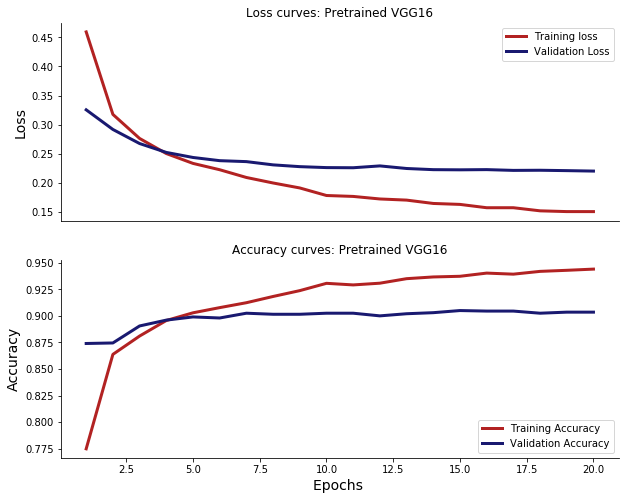

In [14]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,8))

history_dict = history.history
epochs = range(1, len(history_dict['acc'])+1)

ax0.plot(epochs, history_dict['loss'], 'firebrick', linewidth=3.0)
ax0.plot(epochs, history_dict['val_loss'], 'midnightblue', linewidth=3.0)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.tick_params(bottom=False)
ax0.set_xticklabels([])
ax0.set_title('Loss curves: Pretrained VGG16')
ax0.set_ylabel('Loss', fontsize=14)
ax0.legend(['Training loss', 'Validation Loss'], loc='best')

ax1.plot(epochs, history_dict['acc'], 'firebrick', linewidth=3.0)
ax1.plot(epochs, history_dict['val_acc'], 'midnightblue' ,linewidth=3.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Accuracy curves: Pretrained VGG16')
ax1.set_xlabel('Epochs ', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')